## Assignment Part 1: Build a baseline model

Enhance the classification model previously built in the session 5 to predict loan defaults using the Lending Club dataset. Please use the 100k row sample as starting point for your model.



In [3]:
python_material_folder_name = "python-material"

In [4]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, make_scorer

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Check if in Google Colab environment
try:
    from google.colab import drive
    # Mount drive
    drive.mount('/content/drive')
    # Set up path to Python material parent folder
    path_python_material = rf"drive/MyDrive/{python_material_folder_name}"
        # If unsure, print current directory path by executing the following in a new cell:
        # !pwd
    IN_COLAB = True
except:
    IN_COLAB = False
    # If working locally on Jupyter Notebook, parent folder is one folder up (assuming you are using the folder structure shared at the beginning of the course)
    path_python_material = ".."

In [5]:
# Read data that was exported from previous session
df = pd.read_csv(f"{path_python_material}/data/2-intermediate/df_out_dsif5.csv")
df.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,hardship_status_filled,last_pymnt_amnt_log,last_pymnt_amnt_capped,loan_id_extracted,emp_title_clean,emp_title_manager,Job Title,Category,int_rate_clean,term_numeric,debt_to_income,loan_amnt_log,grade_encoded,loan_amnt_std,annual_inc_std,loan_amnt_norm,annual_inc_norm,loan_default
0,167338079,4000.0,4000.0,4000.0,36 months,13.08%,134.93,B,B5,cashier,10+ years,MORTGAGE,48000.0,Source Verified,Mar-2020,Current,n,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,Home improvement,115xx,NY,20.25,1.0,Dec-2004,665.0,669.0,0.0,19.0,110.0,4.0,1.0,1988.0,82.8%,12.0,w,3816.34,3816.34,266.950000,266.95,183.66,83.29,0.0,0.0,0.0,May-2020,134.93,Jun-2020,May-2020,669.0,665.0,1.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,3832.0,259024.0,0.0,1.0,0.0,1.0,16.0,9960.0,56.0,0.0,0.0,0.0,59.0,2400.0,1.0,0.0,0.0,1.0,64756.0,NaN,NaN,0.0,0.0,179.0,75.0,38.0,16.0,2.0,NaN,19.0,16.0,19.0,1.0,0.0,2.0,0.0,1.0,5.0,2.0,5.0,2.0,4.0,0.0,0.0,0.0,0.0,75.0,NaN,1.0,0.0,395328.0,11948.0,0.0,17928.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NO_HARDSHIP,4.912140,134.93,167338079,cashier,False,NaN,NaN,0.1308,36.0,0.083333,8.294300,1,-1.196895,-0.367206,0.083969,0.004364,False
1,71016917,24000.0,24000.0,24000.0,60 months,9.16%,500.07,B,B2,ABM,6 years,RENT,57000.0,Source Verified,Feb-2016,Current,n,https://lendingclub.com/browse/loanDetail.acti...,credit_card,Credit card refinancing,708xx,LA,25.33,0.0,Jan-2004,680.0,684.0,0.0,NaN,NaN,10.0,0.0,22697.0,64.5%,24.0,w,4333.29,4333.29,25496.160000,25496.16,19666.71,5829.45,0.0,0.0,0.0,May-2020,500.07,Jun-2020,May-2020,704.0,700.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,61815.0,0.0,3.0,0.0,3.0,14.0,39118.0,72.0,1.0,1.0,2137.0,67.0,35200.0,0.0,7.0,0.0,4.0,6182

## Explanation of steps:

1) **Data Preprocessing:**

    - *Feature Selection:* Identifying key variables that influence loan defaults.
  
        - features = ['loan_amnt', 'int_rate', 'term', 'grade', 'sub_grade', 'annual_inc', 
            'fico_range_low', 'dti', 'home_ownership', 'revol_util', 'verification_status']).

    - *Handling Missing Values:* Using mean imputation to fill in gaps in the data.
  
        - Missing values in the dti and revol_util columns are replaced with the mean of the respective columns.

    - *Transforming Variables:* Removing percentage signs and converting categorical variables into numeric format:
  
        - The revol_util and int_rate columns originally contained percentage signs, which are removed and converted to numeric values.
        - Ordinal categorical variables (grade and sub_grade) are encoded into numeric values.

2) **Feature Engineering:**

    - *Creating New Features:* Adding interaction terms and transformations to capture more information and relationships from the data.
        - Interaction Term: An interaction term between loan_amnt and annual_inc is created.
        - Log Transformation: A log transformation is applied to loan_amnt to reduce skewness.
        - Polynomial Term: A polynomial term is created by squaring revol_util.

3) **Data Transformation:**

    - *Encoding and Scaling:* One-hot encoding categorical variables(term, home_ownership, verification_status) and standardizing continuous variables to ensure they’re on the same scale.

4) **Model Training:**

    - *Splitting Data:* Dividing the data into training and testing sets to evaluate model performance.

    - *Training the Model:* Using Logistic Regression to predict loan defaults.

5) **Model Evaluation:**

    - *Classification Report:* Analyzing precision, recall, and f1-score.

    - *ROC-AUC Score:* Evaluating the model's ability to differentiate between defaulters and non-defaulters.


In [7]:

# Select features and target variable
features = ['loan_amnt', 'int_rate', 'term', 'grade', 'sub_grade', 'annual_inc', 
            'fico_range_low', 'dti', 'home_ownership', 'revol_util', 'verification_status']
X = df[features].copy()
Y = df['loan_default'] 

# print(df[features].isnull().sum()) #Finding any missing values before preprocessing
X['revol_util'] = X['revol_util'].str.rstrip('%').astype(float) # Removing the % sign

# Impute missing values with the mean
imputer = SimpleImputer(strategy='mean')
X[['dti', 'revol_util']] = imputer.fit_transform(X[['dti', 'revol_util']])

# Preprocess 'int_rate' (Convert percentage strings to numeric)
X['int_rate'] = X['int_rate'].str.rstrip('%').astype(float)

# Encode ordinal categorical variables
for col in ['grade', 'sub_grade']:
    le = LabelEncoder()
    X.loc[:, col] = le.fit_transform(X[col])

# Add interaction terms and transformations (Feature Engineering)
X['loan_amnt_annual_inc_interaction'] = X['loan_amnt'] * X['annual_inc']  # Interaction
X['log_loan_amnt'] = np.log1p(X['loan_amnt'])  # Log transformation

X['revol_util_squared'] = X['revol_util'] ** 2  # Polynomial term

# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), ['term', 'home_ownership', 'verification_status']),
        ('scale', StandardScaler(), ['loan_amnt', 'int_rate', 'annual_inc', 'fico_range_low', 
                                      'dti', 'revol_util', 'loan_amnt_annual_inc_interaction', 
                                      'log_loan_amnt', 'revol_util_squared'])
    ],
    remainder='passthrough'
)

# Apply preprocessing
X = preprocessor.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Create and train the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, Y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]
print(classification_report(Y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(Y_test, y_pred_prob))


              precision    recall  f1-score   support

       False       0.88      0.99      0.94     26408
        True       0.45      0.05      0.08      3592

    accuracy                           0.88     30000
   macro avg       0.67      0.52      0.51     30000
weighted avg       0.83      0.88      0.83     30000

ROC-AUC Score: 0.7357236856753269


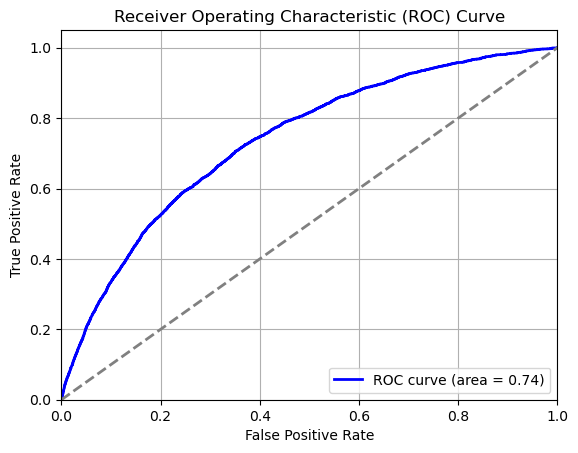

ROC AUC Score: 0.74


In [8]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Compute false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)

# Compute the ROC-AUC score
roc_auc = roc_auc_score(Y_test, y_pred_prob)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonal line (random prediction)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

print(f'ROC AUC Score: {roc_auc:.2f}')

## Cross Validation


In [10]:
from sklearn.model_selection import cross_val_score

# Perform 5-Fold Cross-Validation
cv_scores = cross_val_score(model, X, Y, cv=5, scoring='accuracy')

# Display results
print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

Cross-Validation Accuracy Scores: [0.8741  0.87515 0.87495 0.87425 0.8731 ]
Mean CV Accuracy: 0.8743


## Evaluation and Comparision of Model_1 and Model_2

1. **Comparison of Evaluation Metrics (Accuracy, Precision, Recall, F1-Score, and ROC-AUC)**
   
A bar chart can be used to compare these metrics side-by-side between Model 1 and Model 2.

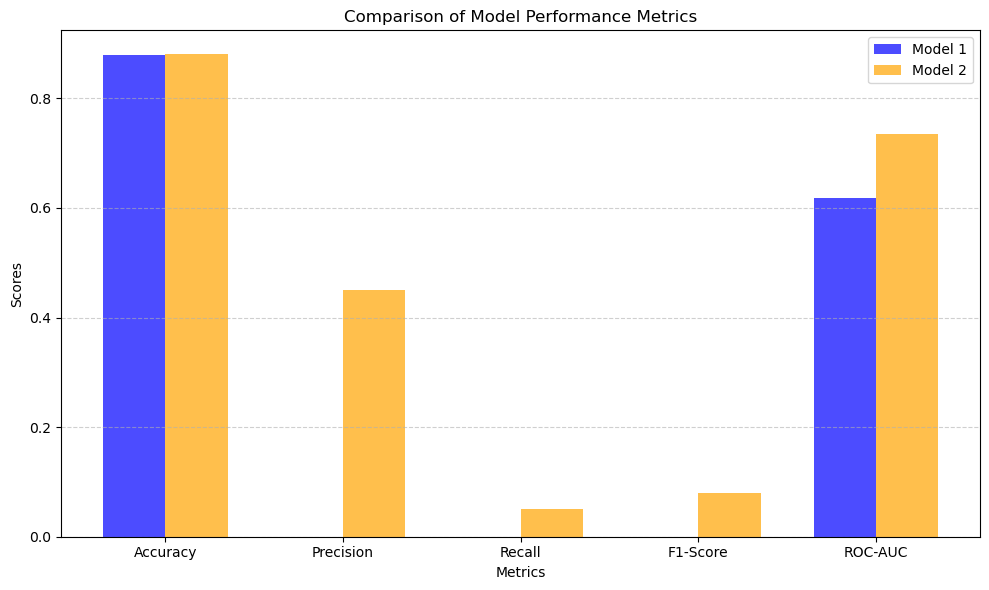

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Define metrics for both models
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
model_1_scores = [0.87835, 0.0, 0.0, 0.0, 0.6174]
model_2_scores = [0.88, 0.45, 0.05, 0.08, 0.7357]

# Create bar chart
x = np.arange(len(metrics))  # Create positions for the bars
width = 0.35  # Width of bars

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, model_1_scores, width, label='Model 1', color='blue', alpha=0.7)
ax.bar(x + width/2, model_2_scores, width, label='Model 2', color='orange', alpha=0.7)

# Add labels, title, and legend
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Model Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend(loc='best')
ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


## Interpretation:
- The bar chart highlights Model 2's significant improvement in ROC-AUC (0.7357 vs. 0.6174).

- Although precision, recall, and F1-score for Model 2 are still low, they are non-zero, whereas Model 1 fails entirely in these areas (0.0 for all three metrics).

2. **Cross-Validation Accuracy** :
A line plot or table can be used to compare the cross-validation accuracy results across folds.

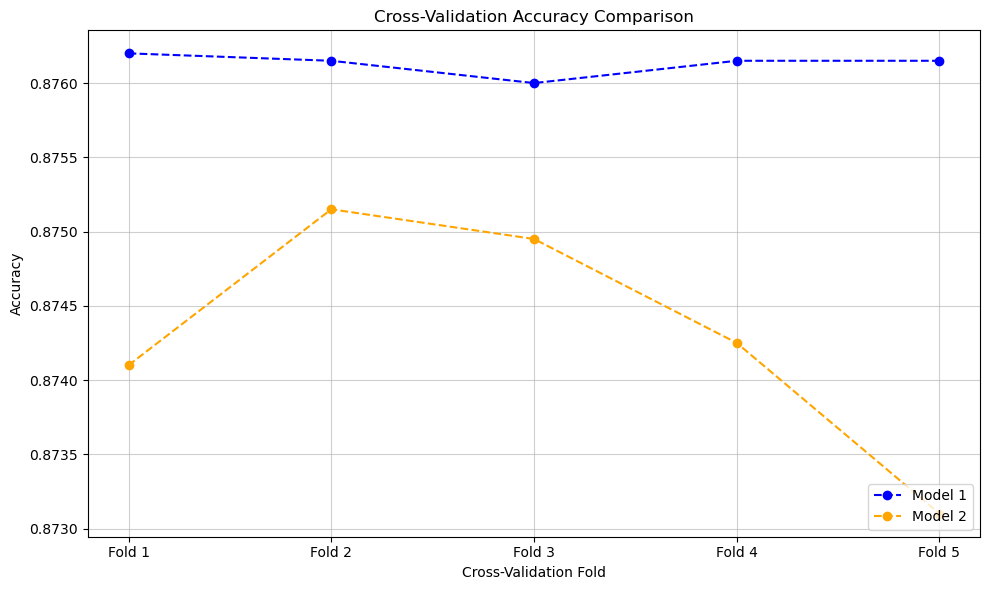

In [33]:
# Cross-validation accuracy for both models
folds = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']
model_1_cv = [0.8762, 0.87615, 0.876, 0.87615, 0.87615]
model_2_cv = [0.8741, 0.87515, 0.87495, 0.87425, 0.8731]

# Plot cross-validation comparison
plt.figure(figsize=(10, 6))
plt.plot(folds, model_1_cv, marker='o', label='Model 1', color='blue', linestyle='--')
plt.plot(folds, model_2_cv, marker='o', label='Model 2', color='orange', linestyle='--')

plt.xlabel('Cross-Validation Fold')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Accuracy Comparison')
plt.legend(loc='lower right')
plt.grid(alpha=0.6)

plt.tight_layout()
plt.show()


## Interpretation:
- While Model 1 achieves slightly better cross-validation accuracy, the difference is marginal (0.8761 vs. 0.8743).
- Considering ROC-AUC, which better reflects the imbalanced dataset, Model 2 is the preferable choice.

# Final Summary
## Key Reasons Model 2 is Better:

- Higher ROC-AUC: Model 2 excels at separating defaults from non-defaults (AUC = 0.7357 vs. 0.6174 for Model 1).

- Improved Metrics: Precision, recall, and F1-score, although modest, are better than the 0.0 values of Model 1.

- Advanced Feature Engineering: Model 2 incorporates additional features, interaction terms, and transformations, leading to better predictive power.

- Marginal Drop in Cross-Validation Accuracy: The slight decrease in cross-validation accuracy is outweighed by improvements in other critical metrics.

#### Assignment Part 2 - Optional
As a data scientist working for the business, your objective is to **minimize the average cost of default** and **maximize the average income on loans**. Optimise `model_2` on this basis, leveraging a **custom loss function** (see 7.2 below) and considering the **following information on the cost of misclassifying** unseen observations:
##### Misclassification cost, and importance of False Positives and False Negatives:
-   **False Positives (FP)**: Predicting a loan as default when it is not. This can lead to lost opportunities for the lender since a potentially profitable loan is denied. Given the **FP_cost = 100**, the cost is relatively low, but it can accumulate over multiple instances.

-   **False Negatives (FN)**: Predicting a loan as non-default when it actually defaults. This is much more severe because it results in financial loss to the lender. Given the **FN_cost = 1000**, the cost here is much higher, reflecting the significant impact of a loan defaulting when it was predicted otherwise.

In [50]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Train logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predictions probabilities on the test set
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Custom loss function
FP_cost = 100   # Cost for False Positive
FN_cost = 1000  # Cost for False Negative

def custom_loss(y_true, y_pred_prob, threshold):
    # Convert probabilities to binary predictions based on the threshold
    y_pred_bin = (y_pred_prob > threshold).astype(int)
    
    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_bin).ravel()
    
    # Calculate custom loss
    loss = FP_cost * fp + FN_cost * fn
    return loss

# Evaluate model for various thresholds
thresholds = np.arange(0.1, 0.9, 0.01)  # Thresholds from 0.1 to 0.9 with a step of 0.01
losses = [custom_loss(y_test, y_pred_prob, t) for t in thresholds]

# Select the threshold with the minimum loss
best_threshold = thresholds[np.argmin(losses)]  # Threshold corresponding to minimum loss
best_loss = min(losses)  # Minimum loss value

print(f"Best Threshold: {best_threshold}")
print(f"Lowest Custom Loss: {best_loss}")

# Generate predictions using the best threshold
y_pred_optimized = (y_pred_prob > best_threshold).astype(int)

# Evaluate performance with the optimized threshold
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_optimized))


Best Threshold: 0.1
Lowest Custom Loss: 2380900
              precision    recall  f1-score   support

       False       0.94      0.31      0.46     26408
        True       0.14      0.85      0.24      3592

    accuracy                           0.37     30000
   macro avg       0.54      0.58      0.35     30000
weighted avg       0.84      0.37      0.44     30000



### 3. Visualizing the Threshold Optimization
- To make your results more compelling, plot the relationship between threshold and loss:

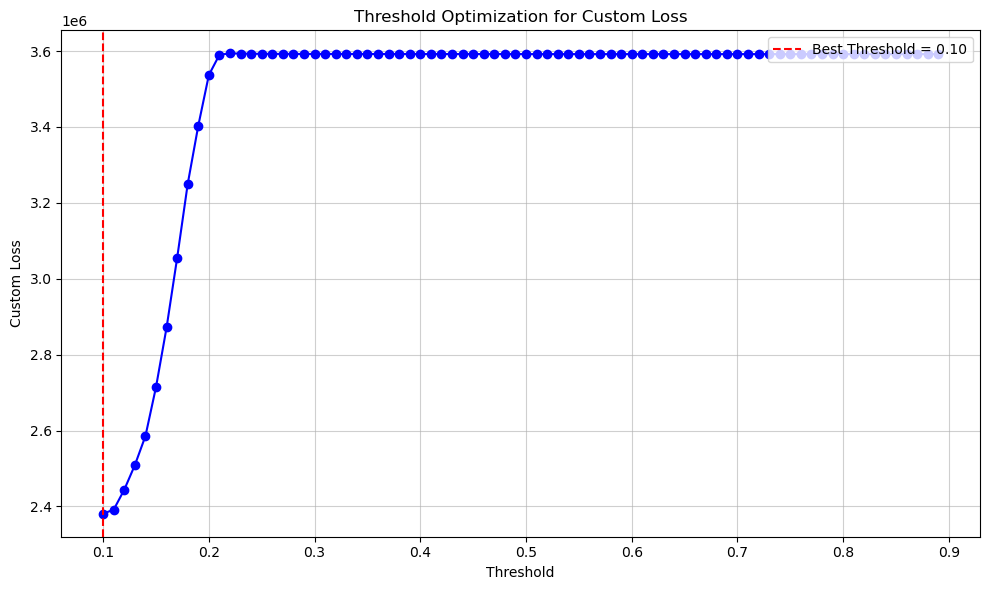

In [52]:
import matplotlib.pyplot as plt

# Plot the custom loss for each threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, losses, marker='o', linestyle='-', color='blue')
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
plt.title('Threshold Optimization for Custom Loss')
plt.xlabel('Threshold')
plt.ylabel('Custom Loss')
plt.legend(loc='upper right')
plt.grid(alpha=0.6)
plt.tight_layout()
plt.show()


### 4. Interpretation of Results
- Best Threshold: This threshold balances the trade-off between False Positives and False Negatives to minimize the total loss.

- Lowest Custom Loss: This value reflects the minimum cost achieved after optimization, considering the relative importance of FP and FN.

- Classification Report: This shows how the model performs (precision, recall, F1-score) after applying the optimized threshold.